In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sphviewer.tools import QuickView
import illustris_python as il
import physics


In [2]:
tng_run = "tng-100-1"
snapshot = 99
test_name = "all_data_1805"
subhalo_id = 438787
subhalos = [76086, 509103, 438787, 601952, 225155]
#subhalos = [509103]
subhalos_kappa = [461202, 271729, 225155]
#subhalos_kappa = [421835]

In [3]:
def stars_out(tng_run, snapshot, i, rad_lim=20):
    #intitial setup
    base_path = "../data/" + str(tng_run) + "/output"
    fields = {"stars": ["Coordinates", "Potential", "Masses", "Velocities", "GFM_StellarPhotometrics"],
            }
    group_cat = pd.DataFrame({"id": [i]})
    #Load particles
    print("Loading stellar particles")

    print("Subhalo ", i)
    stars_dict = il.snapshot.loadSubhalo(base_path, snapshot, i, 'stars', fields["stars"])
    stars = il.pandasformat.dict_to_pandas(stars_dict)
    group_cat = physics.properties.group_properties(group_cat, base_path)
    group_cat = physics.properties.center_halo(stars, group_cat)
    stars = physics.properties.relative_pos_radius(stars, group_cat)
    group_cat = physics.properties.subhalo_velocity(stars, group_cat)
    stars = physics.properties.relative_velocities(stars, group_cat)
    #print(group_cat["SubhaloPosX"][0], group_cat["SubhaloPosY"][0], group_cat["SubhaloPosZ"][0])
    group_cat["SubhaloMassStellarTotal"] = stars["Masses"].sum()
    group_cat = physics.properties.half_mass_radius(stars, group_cat, rad_key="Total")
    max_rad = group_cat["SubhaloGalaxyRad"][0] + rad_lim
    stars = stars[stars["r"] < max_rad]
    return stars

In [4]:
def cumulative_mass(stars, total_mass):
    temp = stars.copy(deep=True)
    temp.sort_values(by="r", inplace=True) #sort particles by radius
    temp = temp.reset_index(drop=True)
    temp_mass = 0
    r = temp["r"].values
    mass_func = np.zeros(len(r))
    for j in range(1, len(r)):
        mass_func[j] = mass_func[j-1] + temp["Masses"][j] #Add mass of next particle
    y = r
    x = mass_func/total_mass
    return x, y

In [ ]:
def galaxy_size_limits(subhalo, group_cat, index, test_name):

    #fig1, axs1 = plt.subplots(nrows = 1, ncols = 2, figsize=(15,9), sharey=True, squeeze=True)
    fig1 = plt.figure(figsize=(14,9))
    ax = fig1.add_gridspec(4, 6, hspace=0.0, wspace=0.0)
    ax1 = fig1.add_subplot(ax[0:, 0:5])
    ax2 = fig1.add_subplot(ax[0:, -2], sharey=ax1)
    
    r_half = group_cat[group_cat["id"] == index]["SubhaloHalfmassRadStellarTotal"].values[0]
    theta = np.linspace(0, 2*np.pi, 100)
    x_half = np.cos(theta)*r_half
    y_half = np.sin(theta)*r_half
    x_half_2 = np.cos(theta)*r_half*2
    y_half_2 = np.sin(theta)*r_half*2
    x_30 = np.cos(theta)*30
    y_30 = np.sin(theta)*30
    gal_rad = group_cat[group_cat["id"] == index]["SubhaloGalaxyRad"].values[0]
    x_15r200 = np.cos(theta)*gal_rad
    y_15r200 = np.sin(theta)*gal_rad
    
    max_rad = max([gal_rad, 30, r_half*2])
    total_mass = group_cat[group_cat["id"] == index]["SubhaloMassStellarTotal"].values[0]

    pos_xyz = np.transpose([subhalo["x_rot"], subhalo["y_rot"], subhalo["z_rot"]])
    pos_xzy = np.transpose([subhalo["x_rot"], subhalo["z_rot"], subhalo["y_rot"]])

    qv_xy = QuickView(pos_xyz, r='infinity', plot=False)
    ax1.imshow(qv_xy.get_image(), extent=qv_xy.get_extent(), cmap="bone")
    ax1.plot(x_half_2, y_half_2, '-', linewidth=3, label=r'$2 \times r^{SUBF}_{hm}$', color="#fec44f")
    ax1.plot(x_30, y_30, '--', linewidth=3, label=r'30 kpc', color="#fe9929")
    ax1.plot(x_15r200, y_15r200, ':', linewidth=3, label=r'$15 \times r_{200}$', color="#d95f0e")
    log_mass = np.round(np.log10(10**10*total_mass/0.67), 2)
    props = dict(boxstyle='round', facecolor='white', alpha=0.9)
    ax1.text(-max_rad*0.97, -max_rad*0.97, r"$M_\ast^{SUBF} = 10^{" + str(log_mass) + r"} M_{\odot}$", 
             fontsize=26, bbox=props, color="black")
    
    mass, rad = cumulative_mass(subhalo, total_mass)
    ax2.plot(mass, rad, c="#7570b3", linewidth=4, label = r"$M_\ast(<r)/M_{\ast}^{SUBF}$")
    ax2.plot(mass, -rad, c="#7570b3", linewidth=4)
    #plot radius lines
    ax2.plot([-1, 2], [r_half*2, r_half*2], color="#fec44f", linewidth=4)
    ax2.plot([-1, 2], [-r_half*2, -r_half*2], color="#fec44f", linewidth=4)
    ax2.plot([-1, 2], [gal_rad, gal_rad], ':', color="#d95f0e", linewidth=4)
    ax2.plot([-1, 2], [-gal_rad, -gal_rad], ':', color="#d95f0e", linewidth=4)
    ax2.plot([-1, 2], [30, 30], "--", color="#fe9929", linewidth=4)
    ax2.plot([-1, 2], [-30, -30], "--", color="#fe9929", linewidth=4)
    
    ax2.set(xlim=(-0.3, 1.3), ylim=(-max_rad - 5, max_rad + 5))
    ax2.tick_params(which="both", direction="inout", labelleft = False, 
                    top=True, right=True, labelsize=18, pad=15, length=4, width=2)
    #ax2.set_xlabel(r"$M(<r)/M_{\ast}^{SF}$", fontsize=20)
    ax2.set_xticks([0, 0.5, 1]) 
    ax2.xaxis.tick_top()
    ax2.legend(loc='lower center', bbox_to_anchor=(0.48, -0.05),
          ncol=3, fancybox=True, shadow=True, fontsize=16)

    il.formatplot.rot_galaxy_map(ax1, max_rad + 5, "x", "y")
    ax1.legend(loc='upper center', bbox_to_anchor=(0.48, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=20)
    ax1.set_facecolor("black")
    ax1.tick_params(which="both", direction="inout", top=True, right=True, labelsize=18, pad=15, length=4, width=2)
    
    fig1.subplots_adjust(hspace=0, wspace=0)
    fig1.tight_layout()
    #plt.show()
    
    folder_path = "../fig/galaxy_sizes/"
    file_path = "galaxy_size_" + str(index) + ".png"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    plt.savefig(folder_path + file_path)
    
rad_lims = [30, 10, 10, 5, 30]
i = 0
for subhalo_id in subhalos:
    new_cat_path = "../data/" + tng_run + "/catalogues/" + test_name + ".pkl"
    group_cat = pd.read_pickle(new_cat_path)
    stellar_mass = group_cat["SubhaloMassStellarTotal"]
    #print(group_cat.keys())
    subhalo_index = group_cat[group_cat["id"] == subhalo_id].index.values.astype(int)[0]
    rot_vector = np.transpose(np.array([group_cat["AngularMomentumX15Rvir"][subhalo_index],
        group_cat["AngularMomentumY15Rvir"][subhalo_index],
        group_cat["AngularMomentumZ15Rvir"][subhalo_index]]))
    subhalo = stars_out(tng_run, snapshot, subhalo_id, rad_lims[i])
    subhalo = physics.geometry.rotate_coordinates(subhalo, rot_vector)
    galaxy_size_limits(subhalo, group_cat, subhalo_id, test_name)
    i = i+1

Loading stellar particles
Subhalo  76086


In [13]:
def create_projections_SPH(subhalo, group_cat, index, test_name, ax1, ax2):
    
    r_half = group_cat[group_cat["id"] == index]["SubhaloHalfmassRadStellar"].values[0]
    theta = np.linspace(0, 2*np.pi, 100)
    x_half = np.cos(theta)*r_half
    y_half = np.sin(theta)*r_half
    x_half_3 = np.cos(theta)*r_half*3
    y_half_3 = np.sin(theta)*r_half*3

    pos_xyz = np.transpose([subhalo["x_rot"], subhalo["y_rot"], subhalo["z_rot"]])
    pos_xzy = np.transpose([subhalo["x_rot"], subhalo["z_rot"], subhalo["y_rot"]])

    qv_xy = QuickView(pos_xyz, r='infinity', plot=False)
    #ax1.imshow(qv_xy.get_image(), extent=qv_xy.get_extent(), cmap="bone")
    ax1.imshow(qv_xy.get_image(), extent=[-r_half*4, r_half*4, -r_half*4, r_half*4], cmap="bone")
    ax1.plot(x_half, y_half, '--', label=r'$r^{SUBF}_{hm}$',color="orange")
    ax1.plot(x_half_3, y_half_3, '-', label=r'$3 \times r^{SUBF}_{hm}$', color="orange")
    
    qv_xz = QuickView(pos_xzy, r='infinity', plot=False)
    ax2.imshow(qv_xz.get_image(), extent=[-r_half*4, r_half*4, -r_half*4, r_half*4], cmap="bone")
    ax2.plot(x_half, y_half, '--', label=r'$r^{SUBF}_{hm}$', color="orange")
    ax2.plot(x_half_3, y_half_3, '-', label=r'$3 \times r^{SUBF}_{hm}}$', color="orange")
    
    return ax1, ax2



Loading stellar particles
Subhalo  461202
Loading stellar particles
Subhalo  271729
Loading stellar particles
Subhalo  225155


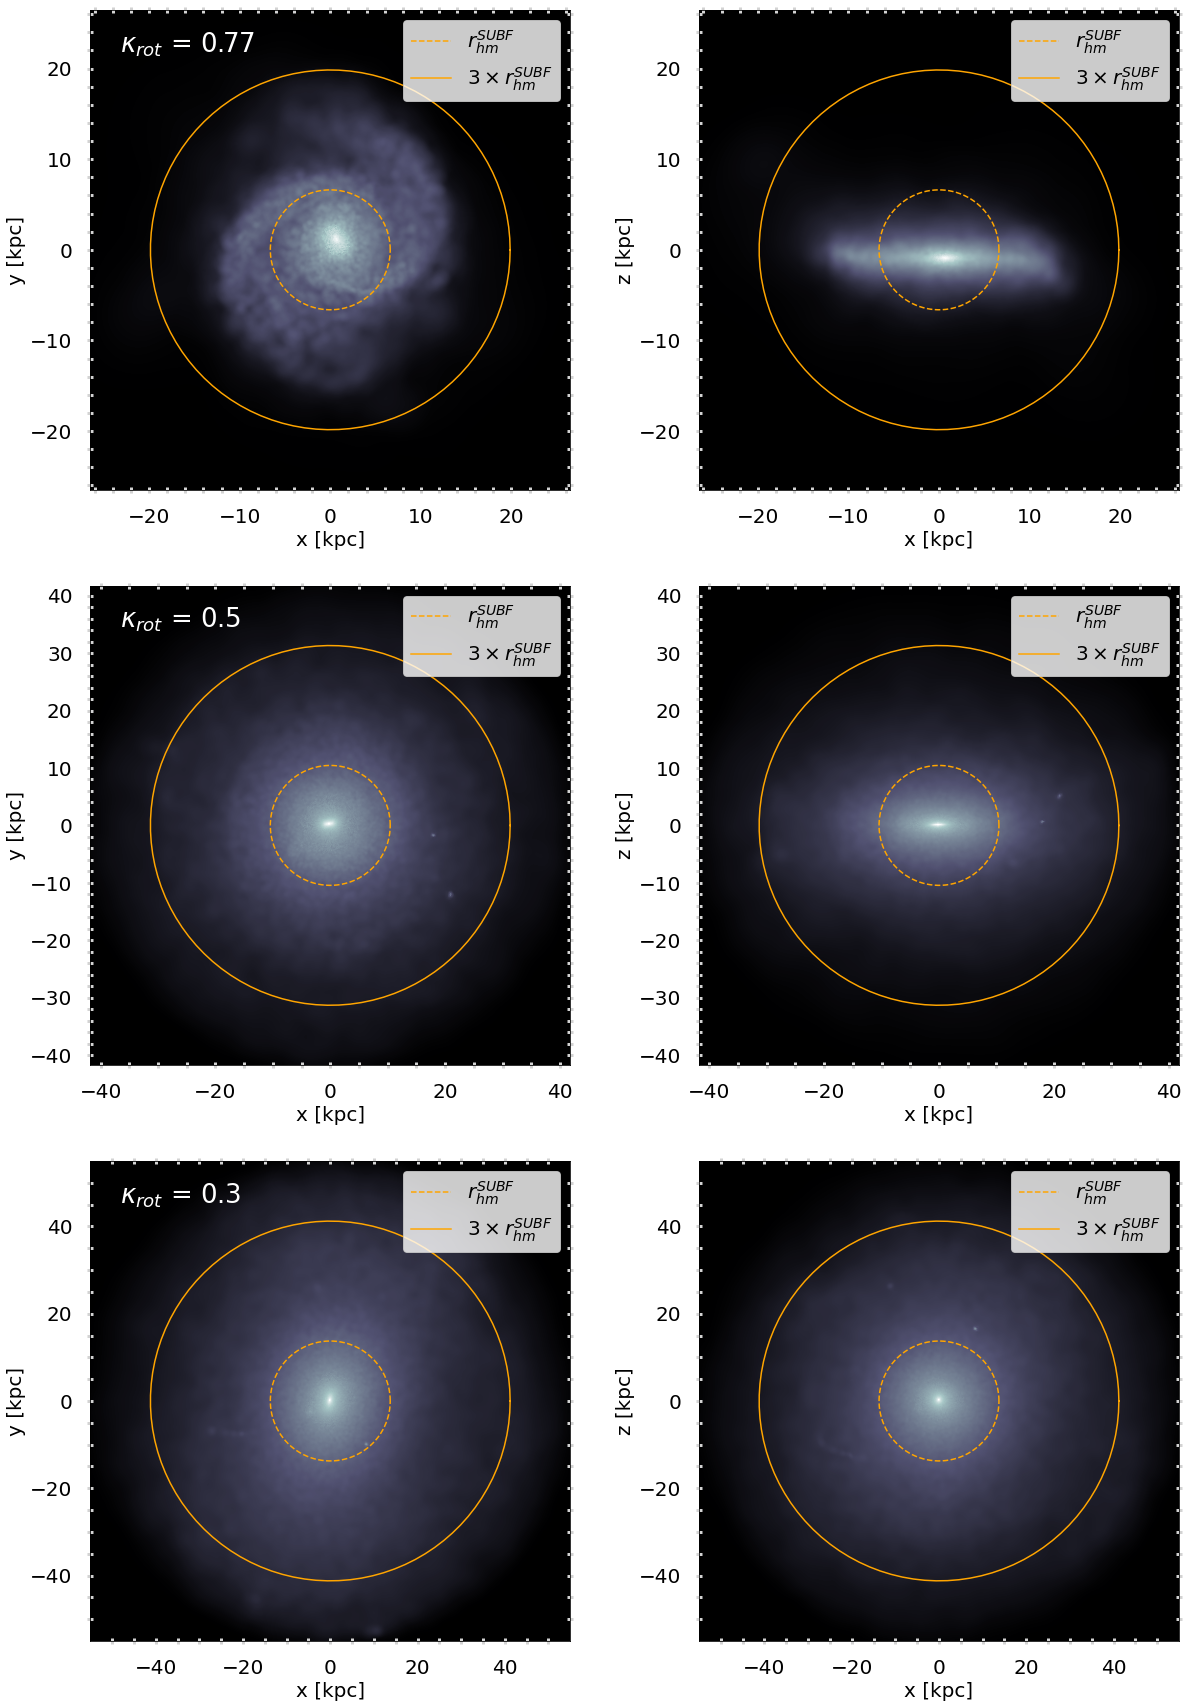

In [17]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize=(20,30))

i = 0
kappas = [0.77, 0.50, 0.30]
for subhalo_id in subhalos_kappa:
    new_cat_path = "../data/" + tng_run + "/catalogues/" + test_name + ".pkl"
    group_cat = pd.read_pickle(new_cat_path)
    subhalo_index = group_cat[group_cat["id"] == subhalo_id].index.values.astype(int)[0]
    rot_vector = np.transpose(np.array([group_cat["AngularMomentumX15Rvir"][subhalo_index],
        group_cat["AngularMomentumY15Rvir"][subhalo_index],
        group_cat["AngularMomentumZ15Rvir"][subhalo_index]]))
    subhalo = stars_out(tng_run, snapshot, subhalo_id, 20)
    subhalo = physics.geometry.rotate_coordinates(subhalo, rot_vector)
    create_projections_SPH(subhalo, group_cat, subhalo_id, test_name, axs[i][0], axs[i][1])
    r_half = group_cat[group_cat["id"] == subhalo_id]["SubhaloHalfmassRadStellar"].values[0]
    axs[i][0].text(-r_half*3.5, +r_half*3.3, r"$\kappa_{rot}$ = " + str(kappas[i]), fontsize=26, color="white")
    il.formatplot.rot_galaxy_map(axs[i][0], r_half*4, "x", "y")
    il.formatplot.rot_galaxy_map(axs[i][1], r_half*4, "x", "z")
    i = i + 1
    
folder_path = "../fig/projections/"
file_path = "kappa_rot.png"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
plt.savefig(folder_path + file_path)

Loading stellar particles
Subhalo  509103


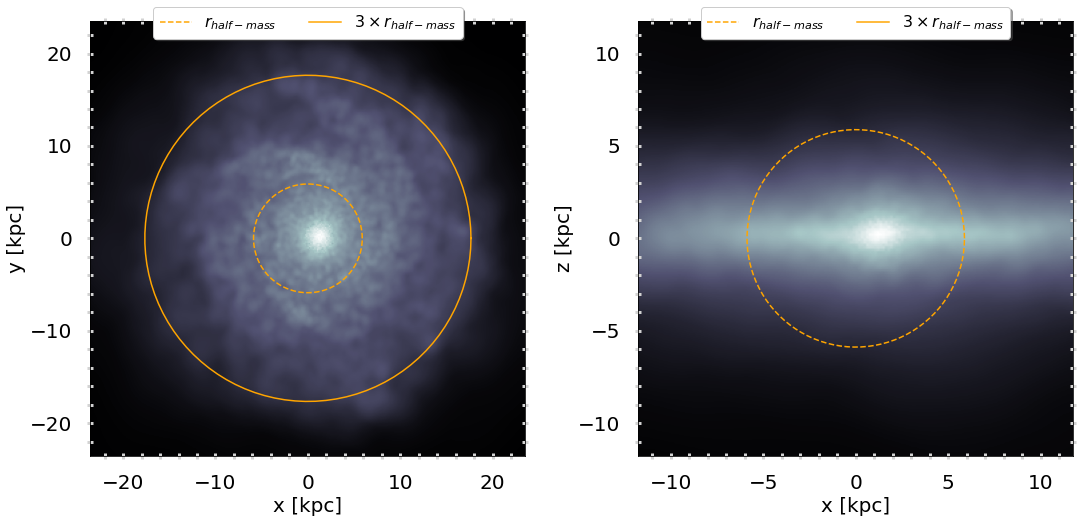

In [8]:
subhalo_id = 509103
new_cat_path = "../data/" + tng_run + "/catalogues/" + test_name + ".pkl"
group_cat = pd.read_pickle(new_cat_path)
subhalo_index = group_cat[group_cat["id"] == subhalo_id].index.values.astype(int)[0]
rot_vector = np.transpose(np.array([group_cat["AngularMomentumX15Rvir"][subhalo_index],
    group_cat["AngularMomentumY15Rvir"][subhalo_index],
    group_cat["AngularMomentumZ15Rvir"][subhalo_index]]))
subhalo = stars_out(tng_run, snapshot, subhalo_id)
subhalo = physics.geometry.rotate_coordinates(subhalo, rot_vector)
pos_xyz = np.transpose([subhalo["x_rot"], subhalo["y_rot"], subhalo["z_rot"]])
pos_xzy = np.transpose([subhalo["x_rot"], subhalo["z_rot"], subhalo["y_rot"]])

r_half = group_cat[group_cat["id"] == subhalo_id]["SubhaloHalfmassRadStellarTotal"].values[0]
theta = np.linspace(0, 2*np.pi, 100)
x_half = np.cos(theta)*r_half
y_half = np.sin(theta)*r_half
x_half_3 = np.cos(theta)*r_half*3
y_half_3 = np.sin(theta)*r_half*3

fig1, axs1 = plt.subplots(nrows = 1, ncols = 2, figsize=(18,8))

qv_xy = QuickView(pos_xyz, r='infinity',plot=False)
axs1[0].imshow(qv_xy.get_image(), extent=qv_xy.get_extent(), cmap="bone")
axs1[0].plot(x_half, y_half, '--', label=r'$r_{half-mass}$',color="orange")
axs1[0].plot(x_half_3, y_half_3, '-', label=r'$3\times r_{half-mass}$', color="orange")

qv_xz = QuickView(pos_xzy, r='infinity', plot=False)
axs1[1].imshow(qv_xz.get_image(), extent=qv_xz.get_extent(), cmap="bone")
axs1[1].plot(x_half, y_half, '--', label=r'$r_{half-mass}$', color="orange")
axs1[1].plot(x_half_3, y_half_3, '-', label=r'$3\times r_{half-mass}$', color="orange")

il.formatplot.rot_galaxy_map(axs1[0], r_half*4, "x", "y")
axs1[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=16)
il.formatplot.rot_galaxy_map(axs1[1], r_half*2, "x", "z")
axs1[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=16)
#plt.savefig("../fig/disk_galaxy.png")